In [1]:
import json
import os
from itertools import combinations
from pathlib import Path
from typing import Literal, TypedDict, Any
from numpy.typing import NDArray

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

load_dotenv()

# check if MPL_STYLE is set in the environment, else use default
if "MPL_STYLE" not in os.environ:
    os.environ["MPL_STYLE"] = "seaborn-v0_8-notebook"
plt.style.use(os.environ["MPL_STYLE"])


In [2]:
class BinningConfig(TypedDict):
    method: Literal["quantile", "uniform"]
    # for quantile: number of quantiles
    # for uniform: bin step length
    n: int | float


OpType = Literal["log", "log1p", "log10", "sqrt"]
DatasetType = Literal["train", "val", "test"]


class StratifiedGroupSplitter:
    def __init__(
        self,
        data_df: pd.DataFrame,
        target_keys: list[str],
        group_key: str = "run_id",
        binning_config: dict[str, BinningConfig] | None = None,
        ops_config: dict[str, OpType] | None = None,
        ratios: tuple[float, float, float] = (0.7, 0.2, 0.1),
        seed: int = 42,
        run_ratio_weight: float = 1.0,
        row_ratio_weight: float = 1.0,
        joint_weight: float = 0.5,
        stratify_pairwise: bool = True,
    ) -> None:
        self._target_keys = target_keys
        self._group_key = group_key
        self._data_df = data_df[self._target_keys + [self._group_key]].copy()

        # binning config with defaults
        self._binning_config = {
            **{k: {"method": "quantile", "n": 20} for k in target_keys},
            **({k: v for k, v in (binning_config or {}).items()}),
        }
        self._ops_config = ops_config if ops_config else {}

        self._ratios = np.array(ratios)
        self._seed = seed

        # weights for the optimization objective
        self._run_ratio_weight = run_ratio_weight
        self._row_ratio_weight = row_ratio_weight
        self._joint_weight = joint_weight
        self._stratify_pairwise = stratify_pairwise

        self._validate()

    def _validate(self) -> None:
        # check for NaNs in columns
        required_keys = [self._group_key] + self._target_keys
        assert not self._data_df[required_keys].isnull().any().any(), (
            f"Expected no NaN values in columns {required_keys}, got:\n"
            f"{self._data_df[self._data_df[required_keys].isnull().any(axis=1)]}"
        )

        # check ratios
        assert len(self._ratios) == 3 and all(r > 0 for r in self._ratios), (
            f"Expected 3 positive ratios, got {self._ratios}"
        )
        assert abs(sum(self._ratios) - 1.0) < 1e-6, (
            f"Expected ratios to sum to 1, got {sum(self._ratios)}"
        )

        # check if all targets have binning config
        assert all(key in self._target_keys for key in self._binning_config.keys()), (
            f"Invalid binning keys: {set(self._binning_config) - set(self._target_keys)}"
        )
        # check binning config validity
        for _, value in self._binning_config.items():
            assert value["method"] in ["quantile", "uniform"]
            assert value["n"] > 0

    def _apply_ops(self, data_df: pd.DataFrame) -> pd.DataFrame:
        mod_data_df = data_df.copy()

        # apply operations on target keys as per config
        for key, op in self._ops_config.items():
            if key not in self._target_keys:
                continue
            match op:
                case "log":
                    mod_data_df[key] = np.log(mod_data_df[key])
                case "log1p":
                    mod_data_df[key] = np.log1p(mod_data_df[key])
                case "sqrt":
                    mod_data_df[key] = np.sqrt(mod_data_df[key])
                case "log10":
                    mod_data_df[key] = np.log10(mod_data_df[key])

        # check for NaNs after operations
        assert not mod_data_df.isnull().any().any(), "NaNs introduced by operations."
        return mod_data_df[[self._group_key] + self._target_keys]

    def _bin_data(self, data_df: pd.DataFrame) -> pd.DataFrame:
        binned_df = data_df.copy()
        for key in self._target_keys:
            # get binning config
            config = self._binning_config[key]
            if config["method"] == "quantile":
                binned_df[key] = pd.qcut(
                    data_df[key], q=int(config["n"]), labels=False, duplicates="drop"
                ).astype(int)
            elif config["method"] == "uniform":
                bin_size = config["n"]
                min_val, max_val = data_df[key].min(), data_df[key].max()
                bins = np.union1d(
                    np.arange(min_val, max_val + bin_size, bin_size), [max_val + 1e-9]
                )

                binned_df[key] = pd.cut(
                    data_df[key], bins=bins, labels=False, include_lowest=True
                ).astype(int)
        return binned_df

    def _build_histogram_specs(self, binned_df: pd.DataFrame) -> dict[str, dict]:
        bins_by_key = {k: binned_df[k].to_numpy(dtype=int) for k in self._target_keys}
        n_bins_by_key = {
            k: max(int(arr.max()) + 1, 1) if arr.size else 1
            for k, arr in bins_by_key.items()
        }

        specs = {
            "marginal": {
                k: {"bins": bins_by_key[k], "n_bins": n_bins_by_key[k], "weight": 1.0}
                for k in self._target_keys
            }
        }

        if self._stratify_pairwise and len(self._target_keys) >= 2:
            specs["joint"] = {
                (a, b): {
                    # flatten 2D index to 1D: idx = i * stride + j
                    "bins": bins_by_key[a] * n_bins_by_key[b] + bins_by_key[b],
                    "n_bins": n_bins_by_key[a] * n_bins_by_key[b],
                    "weight": self._joint_weight,
                }
                for a, b in combinations(self._target_keys, 2)
            }

        return specs

    @staticmethod
    def _compile_histograms(
        group_codes: NDArray[np.int64],
        n_groups: int,
        histogram_specs: dict[str, dict],
    ) -> tuple[NDArray[np.int64], NDArray[np.int64], NDArray[np.float64]]:
        flat_specs = [
            {
                "bins": cfg["bins"],
                "n_bins": int(cfg["n_bins"]),
                "weight": float(cfg["weight"]),
            }
            for g in ("marginal", "joint")
            if g in histogram_specs
            for cfg in histogram_specs[g].values()
        ]

        if not flat_specs:
            return np.array([]), np.zeros((n_groups, 0)), np.array([])

        # create the flattened weight vector
        weights_flat = np.concatenate(
            [np.full(spec["n_bins"], spec["weight"]) for spec in flat_specs]
        )

        # compute group histograms
        group_hists_list = []
        for spec in flat_specs:
            # Calculate 2D histogram for (group, bin)
            # Flatten 2D index: idx = group * n_bins + bin
            flat_indices = group_codes * spec["n_bins"] + spec["bins"]
            counts = np.bincount(flat_indices, minlength=n_groups * spec["n_bins"])
            group_hists_list.append(counts.reshape((n_groups, spec["n_bins"])))

        group_hists_flats = np.hstack(group_hists_list)
        global_hist_flat = group_hists_flats.sum(axis=0)

        return global_hist_flat, group_hists_flats, weights_flat

    def _greedy_split(
        self,
        unique_groups: NDArray[Any],
        rows_per_group: NDArray[np.int64],
        global_hist_flat: NDArray[np.int64],
        group_hists_flat: NDArray[np.int64],
        weights_flat: NDArray[np.float64],
    ) -> dict[str, list[str]]:
        rng = np.random.default_rng(self._seed)

        dataset_type = ["train", "val", "test"]
        n_splits = len(dataset_type)
        n_groups = len(unique_groups)
        total_rows = float(rows_per_group.sum())

        # target counts per split
        target_group_counts = self._ratios * float(n_groups)
        target_row_counts = self._ratios * total_rows

        # current state: (n_splits, total_bins)
        current_split_hists = np.zeros((n_splits, global_hist_flat.size), dtype=float)

        # target state: (n_splits, total_bins)
        # ideally, each split have `ratio * global_count` for every bin
        target_split_hists = self._ratios[:, None] * global_hist_flat[None, :]

        assigned_split = np.full(n_groups, -1, dtype=int)
        current_group_counts = np.zeros(n_splits, dtype=float)
        current_row_counts = np.zeros(n_splits, dtype=float)

        # randomized order of groups to be assigned, largest groups first
        order = np.argsort(-(rows_per_group + rng.normal(0.0, 1e-6, size=n_groups)))

        # assigning initial seeds to each split
        seed_k = min(n_splits, n_groups)
        for s in range(seed_k):
            g_idx = int(order[s])
            assigned_split[g_idx] = s
            current_group_counts[s] += 1.0
            current_row_counts[s] += float(rows_per_group[g_idx])
            current_split_hists[s] += group_hists_flat[g_idx]

        # pre-calculate denominators for ratio penalties to avoid division by zero
        r_denom = np.maximum(target_group_counts, 1.0)
        x_denom = np.maximum(target_row_counts, 1.0)

        # greedily assign remaining groups
        remaining_indices = order[seed_k:]
        for g_idx in tqdm(remaining_indices, desc="Optimizing Splits", leave=False):
            g_idx = int(g_idx)
            add_rows = float(rows_per_group[g_idx])
            group_vec = group_hists_flat[g_idx]

            # calculate ratio penalty change
            # current deviations
            old_r_dev = (current_group_counts - target_group_counts) / r_denom
            old_x_dev = (current_row_counts - target_row_counts) / x_denom

            # new deviations if added to each split
            new_r_dev = (current_group_counts + 1.0 - target_group_counts) / r_denom
            new_x_dev = (current_row_counts + add_rows - target_row_counts) / x_denom

            old_ratio_penalty = (
                self._run_ratio_weight * old_r_dev**2
                + self._row_ratio_weight * old_x_dev**2
            )
            new_ratio_penalty = (
                self._run_ratio_weight * new_r_dev**2
                + self._row_ratio_weight * new_x_dev**2
            )
            delta_ratio_penalty = new_ratio_penalty - old_ratio_penalty

            # calculate histogram penalty change with manhattan distance
            diff_old = current_split_hists - target_split_hists
            dist_old = np.sum(np.abs(diff_old) * weights_flat, axis=1)

            diff_new = diff_old + group_vec[None, :]
            dist_new = np.sum(np.abs(diff_new) * weights_flat, axis=1)

            delta_hist_penalty = dist_new - dist_old

            total_deltas = delta_ratio_penalty + delta_hist_penalty
            best_s = int(np.argmin(total_deltas))

            assigned_split[g_idx] = best_s
            current_group_counts[best_s] += 1.0
            current_row_counts[best_s] += add_rows
            current_split_hists[best_s] += group_vec

        return {
            name: [
                str(unique_groups[i])
                for i in range(n_groups)
                if assigned_split[i] == s_idx
            ]
            for s_idx, name in enumerate(dataset_type)
        }

    def split(self) -> dict[str, list[str]]:
        binned_df = self._bin_data(self._apply_ops(self._data_df))

        group_codes, unique_groups = pd.factorize(
            binned_df[self._group_key].to_numpy(), sort=False
        )
        n_groups = len(unique_groups)
        rows_per_group = np.bincount(group_codes, minlength=n_groups).astype(int)

        histogram_specs = self._build_histogram_specs(binned_df)

        global_hist_flat, group_hists_flat, weights_flat = self._compile_histograms(
            group_codes=group_codes,
            n_groups=n_groups,
            histogram_specs=histogram_specs,
        )

        return self._greedy_split(
            unique_groups=unique_groups,
            rows_per_group=rows_per_group,
            global_hist_flat=global_hist_flat,
            group_hists_flat=group_hists_flat,
            weights_flat=weights_flat,
        )


In [3]:
OUTPUT_BASE = Path(os.getenv("OUTPUT_BASE"))
MASS_LV_UPPER_LIMIT = 6

# prepare data
raw_stats_df = pd.read_parquet(
    OUTPUT_BASE / "cache" / "stats" / "overall_stats.parquet"
)
stats_df = raw_stats_df[
    (raw_stats_df["init_mass_lv"] >= MASS_LV_UPPER_LIMIT)
    & (raw_stats_df["timestamp"] != 0)
    & (raw_stats_df["galactic_x"] == 50)
    & (raw_stats_df["within_2x_r_tidal_n_star"] >= 10)
].copy()
del raw_stats_df
# prepare IDs for each run
stats_df["run_id"] = stats_df.apply(
    lambda row: f"Rad{int(row['init_gc_radius']):02d}"
    f"-zmet{int(row['init_metallicity']):04d}"
    f"-M{int(row['init_mass_lv'])}"
    f"-{int(row['init_pos']):04d}",
    axis=1,
)

In [4]:
attr_group_keys = ["init_gc_radius", "init_metallicity", "init_mass_lv"]

split_config = {
    "target_keys": ["within_2x_r_tidal_total_mass", "timestamp"],
    "ops_config": {"within_2x_r_tidal_total_mass": "log10"},
    "run_ratio_weight": 1,
    "row_ratio_weight": 0.05,
    "ratios": (0.7, 0.2, 0.1),
}


all_splits = {"train": [], "val": [], "test": []}
for group_labels, group_df in stats_df.groupby(attr_group_keys):
    group_split = StratifiedGroupSplitter(
        data_df=group_df,
        **split_config,
    ).split()

    for ds_type, run_ids in group_split.items():
        all_splits[ds_type].extend(run_ids)

split_results = all_splits

train_df = stats_df[stats_df["run_id"].isin(split_results["train"])]
val_df = stats_df[stats_df["run_id"].isin(split_results["val"])]
test_df = stats_df[stats_df["run_id"].isin(split_results["test"])]

# validate no overlaps
for dataset_a, dataset_b in combinations(["train", "val", "test"], 2):
    overlap = set(split_results[dataset_a]).intersection(set(split_results[dataset_b]))
    assert len(overlap) == 0, f"Overlap between {dataset_a} and {dataset_b}: {overlap}"

# validate no missing or extra runs
full_df = pd.concat([train_df, val_df, test_df], axis=0)
assert set(full_df["run_id"]) == set(stats_df["run_id"]), (
    f"Split coverage mismatch: "
    f"missing runs {set(stats_df['run_id']) - set(full_df['run_id'])}, "
    f"extra runs {set(full_df['run_id']) - set(stats_df['run_id'])}."
)

# print summary
print(f"Train: {len(split_results['train'])} runs, {len(train_df)} rows")
print(f"Val: {len(split_results['val'])} runs, {len(val_df)} rows")
print(f"Test: {len(split_results['test'])} runs, {len(test_df)} rows")

Optimizing Splits:   0%|          | 0/69 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/126 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/283 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/64 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/125 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/284 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/63 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/118 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/298 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/62 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/132 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/252 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/59 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/131 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/286 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/66 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/134 [00:00<?, ?it/s]

Optimizing Splits:   0%|          | 0/267 [00:00<?, ?it/s]

Train: 1940 runs, 171116 rows
Val: 603 runs, 47275 rows
Test: 330 runs, 22830 rows


In [5]:
# calculate SWD
scaler = StandardScaler()
full_features = np.column_stack(
    [
        full_df["timestamp"].values,
        np.log10(full_df["within_2x_r_tidal_total_mass"].values),
    ]
)
scaled_full_features = scaler.fit_transform(full_features)

swd_results = {}
for df_name, subset_df in (
    pbar := tqdm(
        [("Train", train_df), ("Val.", val_df), ("Test", test_df)],
        leave=False,
    )
):
    pbar.set_description(f"Calc. SWD for {df_name}")
    subset_features = np.column_stack(
        [
            subset_df["timestamp"].values,
            np.log10(subset_df["within_2x_r_tidal_total_mass"].values),
        ]
    )
    scaled_subset_features = scaler.transform(subset_features)

    swd_results[df_name] = ot.sliced.sliced_wasserstein_distance(
        scaled_full_features,
        scaled_subset_features,
        n_projections=int(1e3),
        seed=42,
    )

print(swd_results)

  0%|          | 0/3 [00:00<?, ?it/s]

{'Train': np.float64(0.0072179607882091575), 'Val.': np.float64(0.017234832730233542), 'Test': np.float64(0.030567866267474347)}


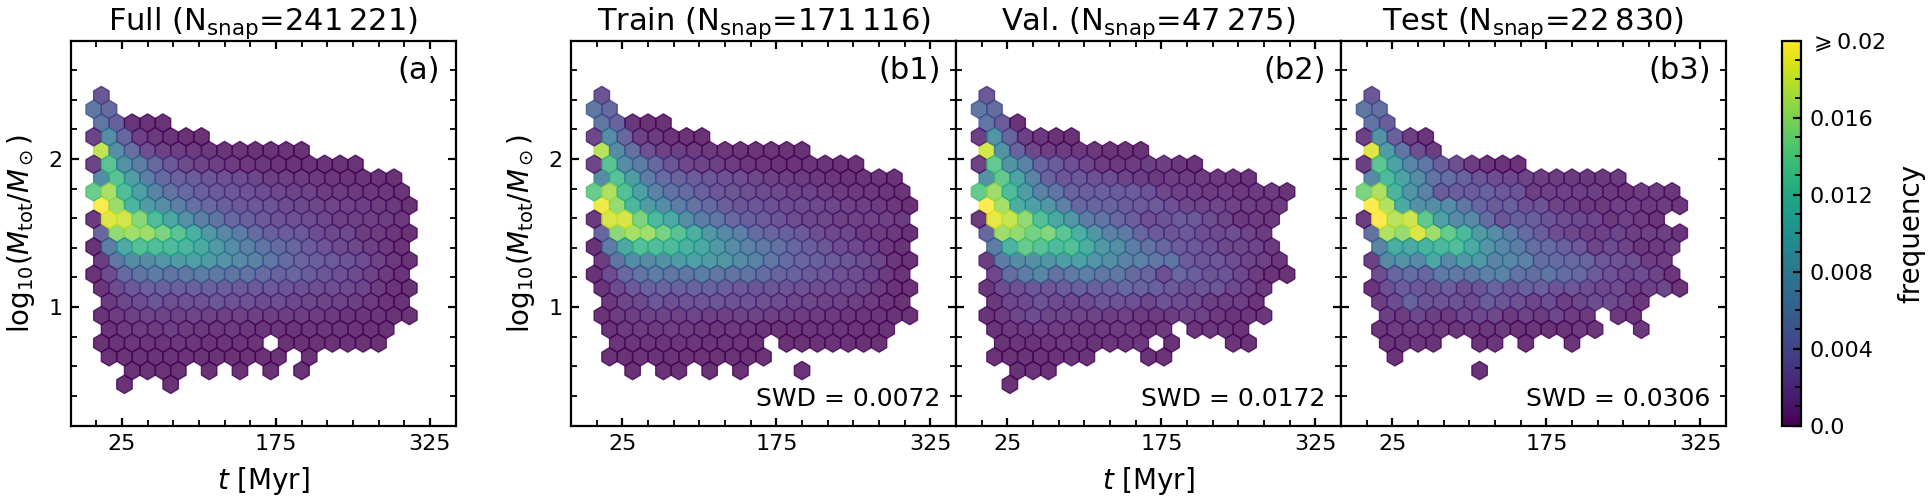

In [6]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(24, 5),
    width_ratios=[5, 1.5, 5, 5, 5],
    gridspec_kw=dict(wspace=0),
)

# disable phantom axis
axes[1].axis("off")

full_ax = axes[0]
subset_ax = axes[2:]

x_plot_lim = (-25, 350)
y_plot_lim = (0.2, 2.8)
cbar_map_lim = (0, 0.02)
cbar_tick_step = 0.004

cmap = "viridis"
norm = mcolors.Normalize(vmin=cbar_map_lim[0], vmax=cbar_map_lim[1])

for ax_idx, (ax, stats_df, df_label) in enumerate(
    zip(
        [full_ax] + list(subset_ax),
        [full_df, train_df, val_df, test_df],
        ["Full", "Train", "Val.", "Test"],
    )
):
    ax.title.set_text(
        rf"{df_label} (N$_\mathrm{{snap}}$={len(stats_df):,})".replace(
            ",", "\N{THIN SPACE}"
        )
    )
    ax.title.set_fontsize(22)

    ax.text(
        0.96,
        0.96,
        f"(b{ax_idx})" if ax in subset_ax else "(a)",
        va="top",
        ha="right",
        fontsize=22,
        transform=ax.transAxes,
    )

    ax.hexbin(
        x=stats_df["timestamp"],
        y=np.log10(stats_df["within_2x_r_tidal_total_mass"]),
        gridsize=25,
        extent=(x_plot_lim[0], x_plot_lim[1], y_plot_lim[0], y_plot_lim[1]),
        # color bar
        cmap=cmap,
        norm=norm,
        mincnt=2,
        alpha=0.8,
        # use frequency as color reference
        C=np.ones(len(stats_df)),
        reduce_C_function=lambda x: np.sum(x) / len(stats_df),
    )
    # SWD
    if ax in subset_ax:
        ax.text(
            0.96,
            0.04,
            f"SWD = {swd_results[df_label]:.4f}",
            va="bottom",
            ha="right",
            fontsize=18,
            transform=ax.transAxes,
        )

    if ax not in [subset_ax[1], full_ax]:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [Myr]", fontsize=20)
    ax.set_xlim(x_plot_lim)
    ax.xaxis.set_major_locator(plt.MultipleLocator(150, offset=25))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(25))

    if ax not in [subset_ax[0], full_ax]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(
            r"$\log_{10}\!\left(M_{\mathrm{tot}}/M_\odot\right)$", fontsize=20
        )
    ax.set_ylim(y_plot_lim)
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.2))


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(
    sm,
    ax=axes,
    orientation="vertical",
    fraction=0.08,
    pad=0.03,
)
cbar.set_label("frequency", fontsize=20)

cbar.ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
cbar_labels = np.arange(
    start=cbar_map_lim[0],
    stop=cbar_map_lim[1] + cbar_tick_step,
    step=cbar_tick_step,
)
cbar.set_ticks(cbar_labels)
cbar.set_ticklabels(
    list(np.round(cbar_labels[:-1], 4)) + [rf"$\geqslant{cbar_labels[-1]}$"]
)

# save figure
fig_export_path = OUTPUT_BASE / "figures"
fig_export_path.mkdir(parents=True, exist_ok=True)
fig.savefig(
    fig_export_path / f"dataset_split_swd-M{MASS_LV_UPPER_LIMIT}.pdf",
    dpi=300,
    bbox_inches="tight",
)

In [7]:
# export run_id to JSON for downstream use
json.dump(
    {**split_config, **split_results},
    open(
        OUTPUT_BASE / "cache" / "stats" / f"run_id_splits-M{MASS_LV_UPPER_LIMIT}.json",
        "w",
    ),
    indent=4,
)